In [4]:
import torch
import numpy as np
from se3_transformer_pytorch import SE3Transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import ase.io
from collections import defaultdict, namedtuple
import torch.autograd as auto
from math import sqrt
from itertools import product
import sys
sys.path.append("./se3_trans")
import torch
import mendeleev
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import random
import pickle
from ase import Atoms

torch.set_default_dtype(torch.float64) # works best in float64?
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import clear_output

%config InlineBackend.figure_format='retina'


# %matplotlib widget

In [5]:
class Data(Dataset):
    def __init__(self, path: str, pickle_path='data.pickle', normalize=True, defect=None):
        self.pickle_path = pickle_path
        self.defect = defect
        self.normalize = normalize
        self.mean_std = []
        self.data = []
        try:
            with open(self.pickle_path, 'rb') as f:
                self.data = pickle.load(f)
                
        except FileNotFoundError:
            print('File not found processing the data')
            self.data_raw = self.get_gpaw_trajectories(path)
            self.setup()

    def setup(self):
        for id, atoms_ in self.data_raw.items():
            for num, data in enumerate(atoms_):
                for i, atoms in enumerate(data[:-2]):
                    data_dict = {
                        'input': {
                            'coord':    self.tensor(atoms.positions),
                            'energy':   torch.tensor(atoms.get_potential_energy()),
                            'force':    self.tensor(atoms.get_forces()),
                            'features': self.tensor([self.compute_species_params(int(n)) for n in atoms.get_atomic_numbers()])
                                              }, # Randomly choose initial structure 
                        'target': {     # Relaxed structure
                            'coord':    self.tensor(data[-1].positions),
                            'energy':   torch.tensor(data[-1].get_potential_energy()),
                            'force':    self.tensor(data[-1].get_forces()),
                            'features': self.tensor([self.compute_species_params(int(n)) for n in data[-1].get_atomic_numbers()])
                                    },
                        'id': id
                                }
                    self.data.append(data_dict)
                    print(f'ID: {id}, Processed: {num} sample, # Atom {i}')

        # Save the list of proccessed data        
        with open(self.pickle_path, 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.data, f, pickle.HIGHEST_PROTOCOL)
    
    
    def __getitem__(self, idx):
        return self.data[idx]
        
            
    def __len__(self):
        return len(self.data)
    
    def compute_species_params(self, charge):
        element = mendeleev.element(charge)
        return [charge, element.atomic_volume, element.group_id, element.period]
                                    
    def tensor(self, x):
        if not self.normalize:
            return torch.from_numpy(x)
        return torch.tensor(self.norm(x))
    
    def norm(self, x):
        std = np.std(x)
        mean = np.mean(x)
        self.mean_std.append((mean, std))
        return (x / (std + 1e-8)) - mean
    
    def denorm(self, x):
        std = np.std(x)
        mean = np.mean(x)
        return (x * std) + mean
        
    def get_gpaw_trajectories(self, defect_db_path:str):
        res = defaultdict(list)
        for file_ in os.listdir(defect_db_path):
            if not file_.startswith("id"):
                continue
            this_folder = os.path.join(defect_db_path, file_, "relaxed", "trajectory")
            for traj_file in os.listdir(this_folder):
                try:
                    res[file_].append(ase.io.read(os.path.join(this_folder, traj_file), index=":"))
                except ase.io.formats.UnknownFileTypeError:
                    pass
        return res


dataset = Data("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [6]:
from se3_transformer_pytorch import SE3Transformer
from se3_transformer_pytorch.se3_transformer_pytorch import FeedForwardSE3
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.IS2RS = SE3Transformer(
            dim = 4,
            heads = 4,
            depth = 4,
            dim_head = 8,
            input_degrees = 1,
            output_degrees = 2,
            num_degrees = 2,
            valid_radius = 5,
            reduce_dim_out = True,
            differentiable_coors = True,
            causal = False
        )

#         self.IS2RS = SE3Transformer(
#             num_tokens = 28,       # 28 unique atoms
#             dim = 64,
#             depth = 2,
#             input_degrees = 1,
#             num_degrees = 2,
#             output_degrees = 2,
#             reduce_dim_out = True
#         )

 
#         self.S2EF = SE3Transformer(
#             dim = 3,
#             heads = 4,
#             depth = 4,
#             dim_head = 8,
#             num_degrees = 2,
#             valid_radius = 5,
#             reduce_dim_out = False,
#             causal = False
#         )
        
        
#         self.lin_1 = nn.Linear(3, 32)
#         self.lin_2 = nn.Linear(32, 32)
#         self.lin_3 = nn.Linear(32, 1)
    
    def forward(self, cord, feat, mask, return_type=None):
        rs = self.IS2RS(cord, feat, mask, return_type)
#         rs_em = self.S2EF(cord, feat, mask)
#         out = F.relu(self.lin_1(rs['1']))
#         out = F.relu(self.lin_2(out))
#         out = self.lin_3(out)
        return None, rs

def batch_dim(x):
    return x.unsqueeze(0)


In [7]:
def plotatoms(coord_input, coord_target):
    fig, axs = plt.subplots(1, 3, figsize=(10,10))

    input_atom = Atoms(positions=coord_input)
    target_atom = Atoms(positions=coord_target.detach())

    plot_atoms(input_atom, ax=axs[0])
    plot_atoms(target_atom, colors=['g' for _ in range(coord_target.shape[0])], ax=axs[1])
    
    plot_atoms(input_atom, ax=axs[2])
    plot_atoms(target_atom, colors=['g' for _ in range(coord_target.shape[0])], ax=axs[2])


In [8]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

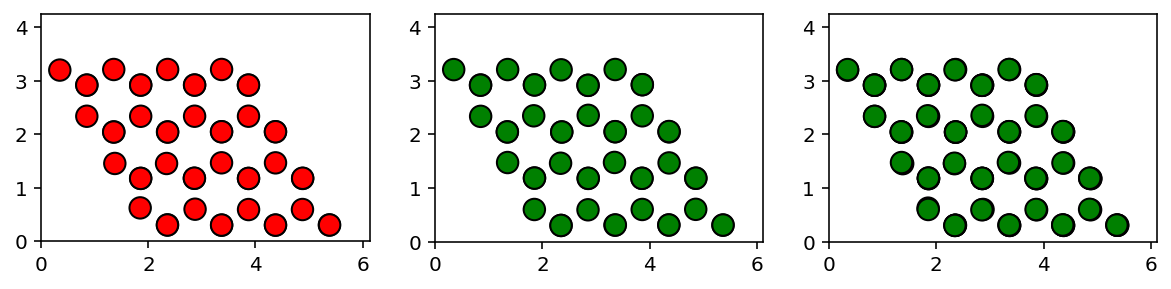

In [11]:
model = Model()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
# optimizer.load_state_dict(state_dict['optimizer_state_dict'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=0)
# scheduler = get_cosine_schedule_with_warmup(optimizer, 500, 5000)

try: 
    checkpoint = torch.load('checkpoints/checkpoint__diffcoord_1600.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except:
    Print("No checkpoint")


coord = batch_dim(dataset[0]['input']['coord'])    # torch.Size([1, 48, 3])
feats = batch_dim(dataset[0]['input']['features']) # torch.Size([1, 48, 4])
mask  = torch.ones(1, 48).bool()
en, out = model(feats, coord, mask, return_type = 1) # (1, 1024, 512)

refined_coors = coord + out['1'] # (2, 32, 3)

print()
plotatoms(dataset[3]['input']['coord'], refined_coors[0])

In [12]:
force_coefficient = 0.5
losses_en = [0]
losses_f = [0]
losses_coord = [0]

model.train()
model = model.cuda()
optimizer_to(optimizer, 'cuda')

print()


In [176]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader = DataLoader(train_dataset, batch_size=3,
                        shuffle=True, num_workers=4)

In [33]:
train_dataset = iter(train_dataset)

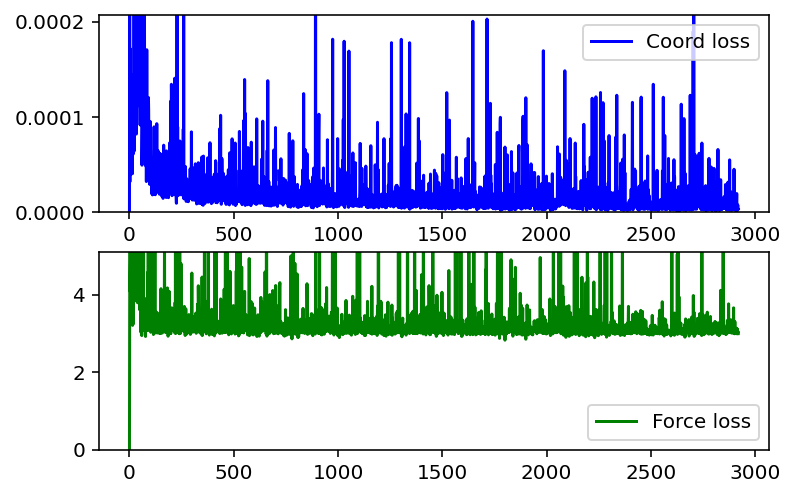

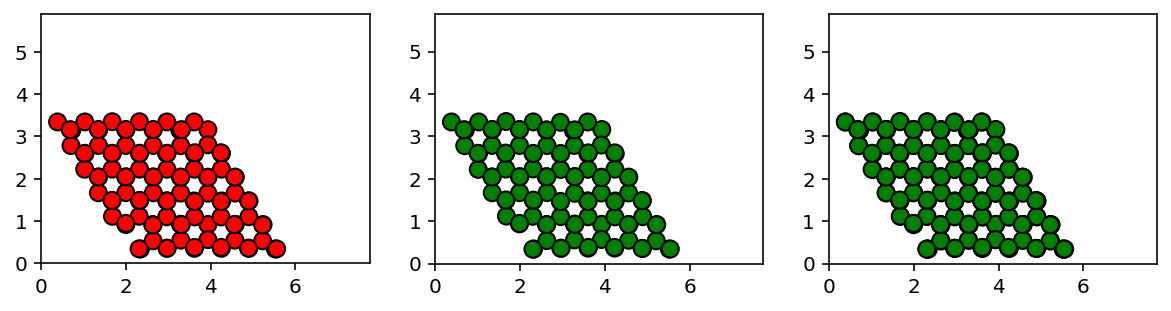

KeyboardInterrupt: 

In [43]:
for iteration in range(1000000):
    data = next(train_dataset)
    # Input
    coord = batch_dim(data['input']['coord']).double().cuda().requires_grad_()
    energy = batch_dim(data['input']['energy']).double().cuda()
    force = batch_dim(data['input']['force']).double().cuda()
    features = batch_dim(data['input']['features']).double().cuda()
    
    # Target    
    coord_target = batch_dim(data['target']['coord']).double().cuda().requires_grad_()
    energy_target = batch_dim(data['target']['energy']).double().cuda()
    force_target = batch_dim(data['target']['force']).double().cuda()
    features_target = batch_dim(data['target']['features']).double().cuda()
    
    
    
    num_atoms = coord.shape[-2]
    bs = coord.shape[0]
    mask = torch.ones(bs, num_atoms).bool().cuda()

    
    pred_energy, pred_coord = model(features, coord, mask)
    pred_coord = pred_coord['1']
    pred_coord += coord            # Refine coordinates
    

    coord_loss = (F.mse_loss(pred_coord, coord_target, reduction='none') / np.sqrt(num_atoms)).mean()
    
#     mse_en = F.mse_loss(pred_energy, energy_target)
    ##############
    _, pred_coord_relaxed = model(features, coord_target, mask)
    ##############
    pred_forces = - auto.grad(pred_coord_relaxed['1'].sum(), coord_target, retain_graph=True,
                       create_graph=True, allow_unused=True)[0]
    mse_f = (F.mse_loss(pred_forces.cuda().double(), force_target, reduction='none').sum(dim=(1, 2)) / num_atoms).mean()
#     mse_en = torch.tensor(0)
#     mse_f = torch.tensor(0)

    loss = coord_loss #+ (mse_f * 0.1) #+ mse_en  * force_coefficient   #
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     scheduler.step(loss)
    
#     losses_en.append(mse_en.item())
    losses_f.append(mse_f.item())
    losses_coord.append(coord_loss.item())

    if iteration % 10 == 0:
        fig, ax = plt.subplots(2,1)

        clear_output(wait=True)

        ax[0].plot(losses_coord, 'b', label='Coord loss')
        ax[0].set_ylim(0, np.max(losses_coord[-1000:]))
        ax[1].plot(losses_f, 'g', label='Force loss')
        ax[1].set_ylim(0, np.max(losses_f[-100:]))
#         ax[2].plot(losses_en, 'g', label='Energy loss')
#         ax[2].set_ylim(0, np.mean(losses_en[-1000:]))

        plotatoms(coord_target.cpu().detach()[0], pred_coord.detach().cpu()[0])

        ax[0].legend()
        ax[1].legend()
#         ax[2].legend()

        plt.show()

        
        
    if iteration % 100 == 0:
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                   }, f'checkpoints/checkpoint__diffcoord_{iteration}.pth')

    
    print(f"{iteration}   loss: {loss.cpu().detach().item():.3f} Energy RMSE: {np.sqrt(losses_en[-1]):.3f} \
        Force RMSE: {np.sqrt(losses_f[-1]):.3f} Coord Loss {coord_loss.cpu().detach().item():.6f}", end='\r')


In [13]:
import sklearn

In [147]:
model_cpu = model.cpu()
model_cpu.eval()
print()

In [185]:
def random_rotation(x, M):
    Q, __ = torch.qr(M)
    return x @ Q
    
def valid(data, rotation=False):
    m = torch.randn(3, 3)

    # Input
    if rotation:
        coord = batch_dim(random_rotation(data['input']['coord'], m)).double()
    else:
        coord = batch_dim(data['input']['coord']).double()
    energy = batch_dim(data['input']['energy']).double()
    force = batch_dim(data['input']['force']).double()
    features = batch_dim(data['input']['features']).double()
    
    # Target    
    if rotation:
        coord_target = batch_dim(random_rotation(data['target']['coord'], m)).double()
    else:
        coord_target = batch_dim(data['target']['coord']).double()
    energy_target = batch_dim(data['target']['energy']).double()
    force_target = batch_dim(data['target']['force']).double()
    features_target = batch_dim(data['target']['features']).double()
    
    
    num_atoms = coord.shape[-2]
    bs = coord.shape[0]
    mask = torch.ones(bs, num_atoms).bool()

    _, out = model_cpu(features, coord, mask)
    
    return coord + out['1'][0].detach(), coord_target[0].detach()

# Random rotation on the structure right is the unrelaxed left in relaxed

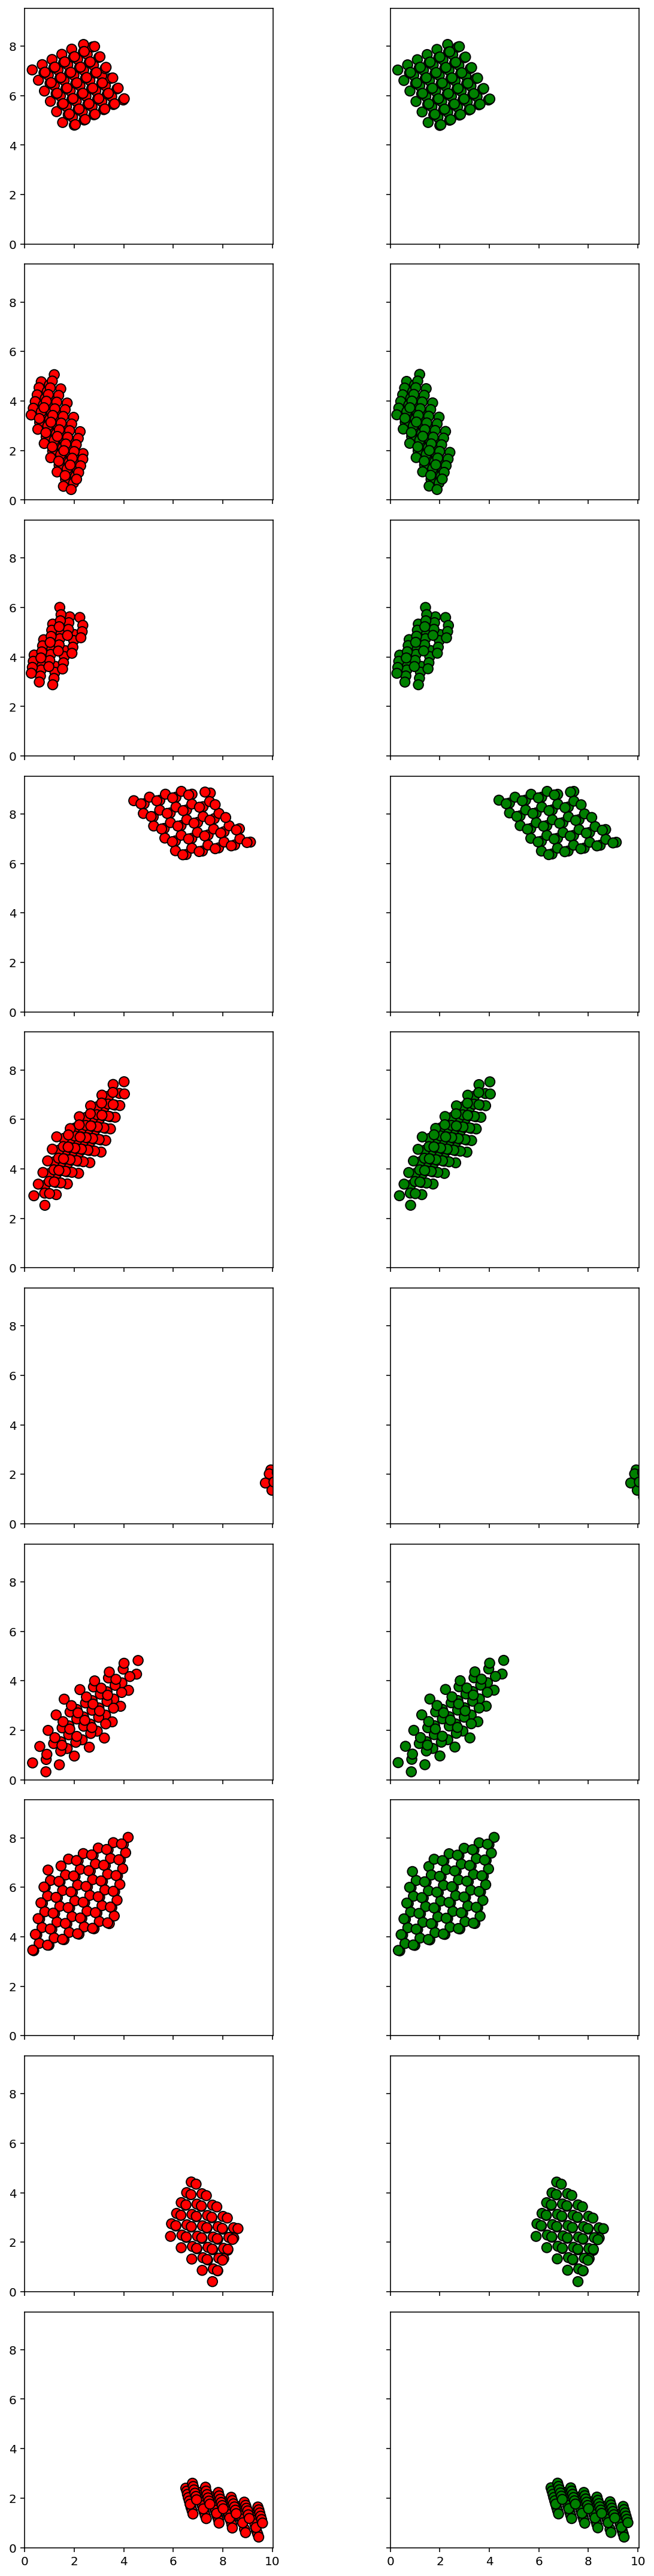

In [190]:
fig, axs = plt.subplots(10, 2, figsize=(10, 30), sharex=True, sharey=True)
for i in range(10):
    coord_pred, coord_target = valid(test_dataset[i], rotation=True)
    coord_pred = coord_pred[0]
    input_atom = Atoms(positions=coord_target)
    target_atom = Atoms(positions=coord_pred)
    plot_atoms(input_atom, ax=axs[i, 0])
    plot_atoms(target_atom, colors=['g' for _ in range(coord_pred.shape[0])], ax=axs[i, 1])
fig.tight_layout()


# Analysis

In [178]:
def plot_analysis(data, pred):
    fig, axs = plt.subplots(2,2, figsize=(20, 10))
    
    axs[0, 0].plot(F.mse_loss(data.sum(1), pred.sum(1), reduction='none'), '.')
    axs[0, 0].set_title('L2 distance of the sum coordinates')
    axs[0, 0].set_xlabel('atoms')
    axs[0, 0].set_ylabel('L2')


    axs[0, 1].plot(data, pred, '.')
    axs[0, 1].set_title('Correlation')
    axs[0, 1].set_xlabel('DFT')
    axs[0, 1].set_ylabel('Predictions')


    img = sklearn.metrics.pairwise_distances(pred, data, metric='l2')
    axs[1, 0].imshow(img)
    axs[1, 0].set_title('L2 Pairwise distances')
    axs[1, 0].set_ylabel('DFT')
    axs[1, 0].set_xlabel('Predictions')



    input_atom = Atoms(positions=data)
    target_atom = Atoms(positions=pred)

    plot_atoms(input_atom, ax=axs[1, 1])
    plot_atoms(target_atom, colors=['g' for _ in range(pred.shape[0])], ax=axs[1, 1])
    axs[1, 1].set_title('Structure')




Sample #0
Sample #1
Sample #2
Sample #3
Sample #4


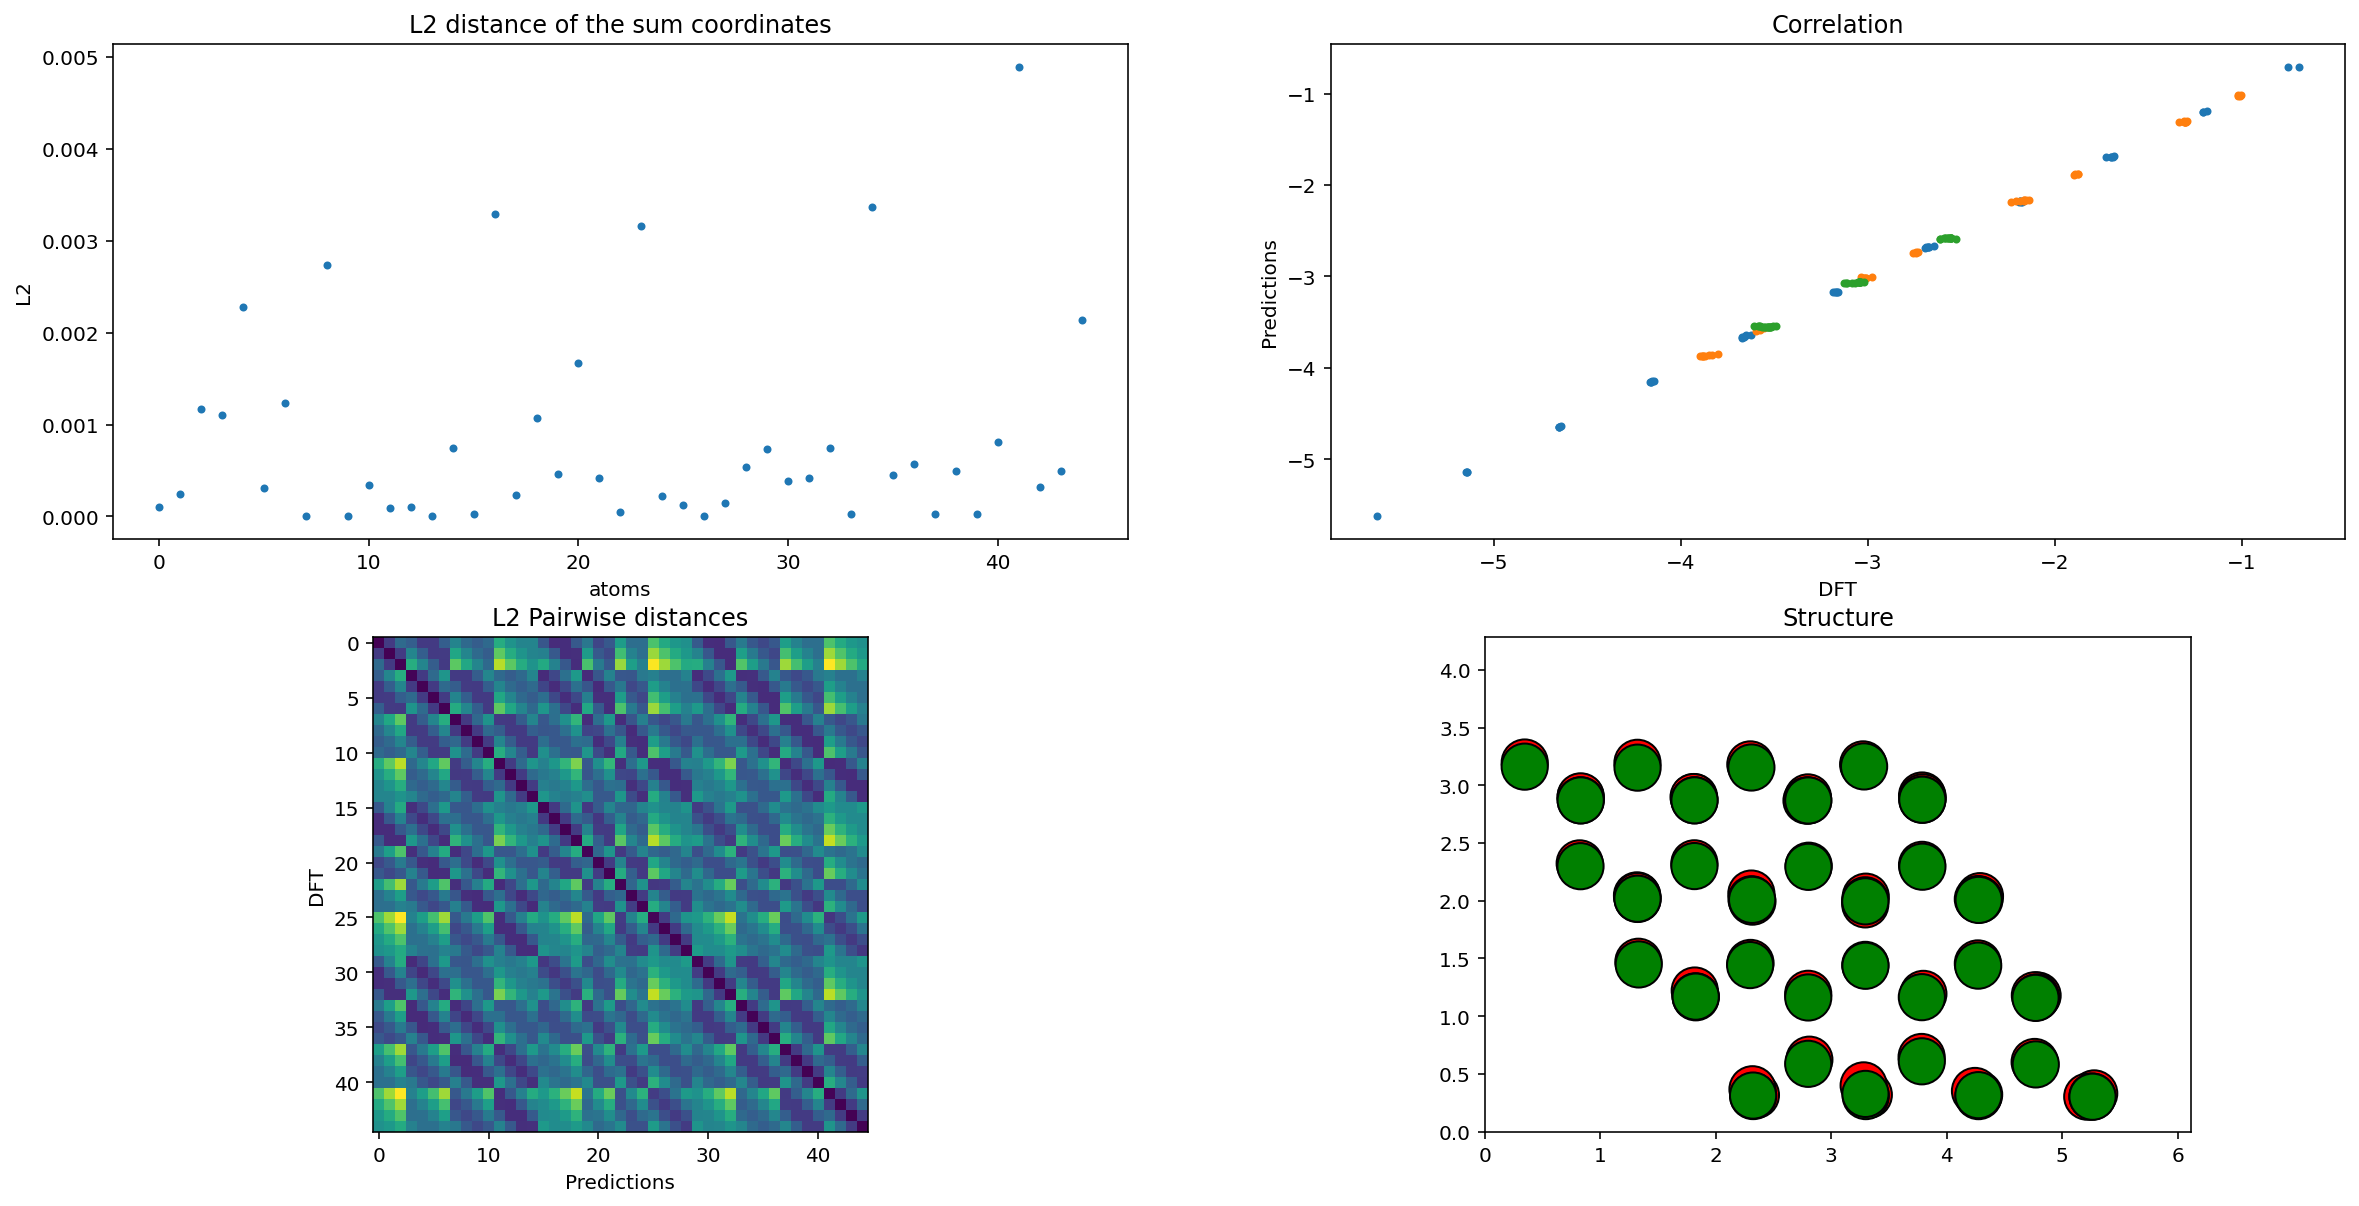

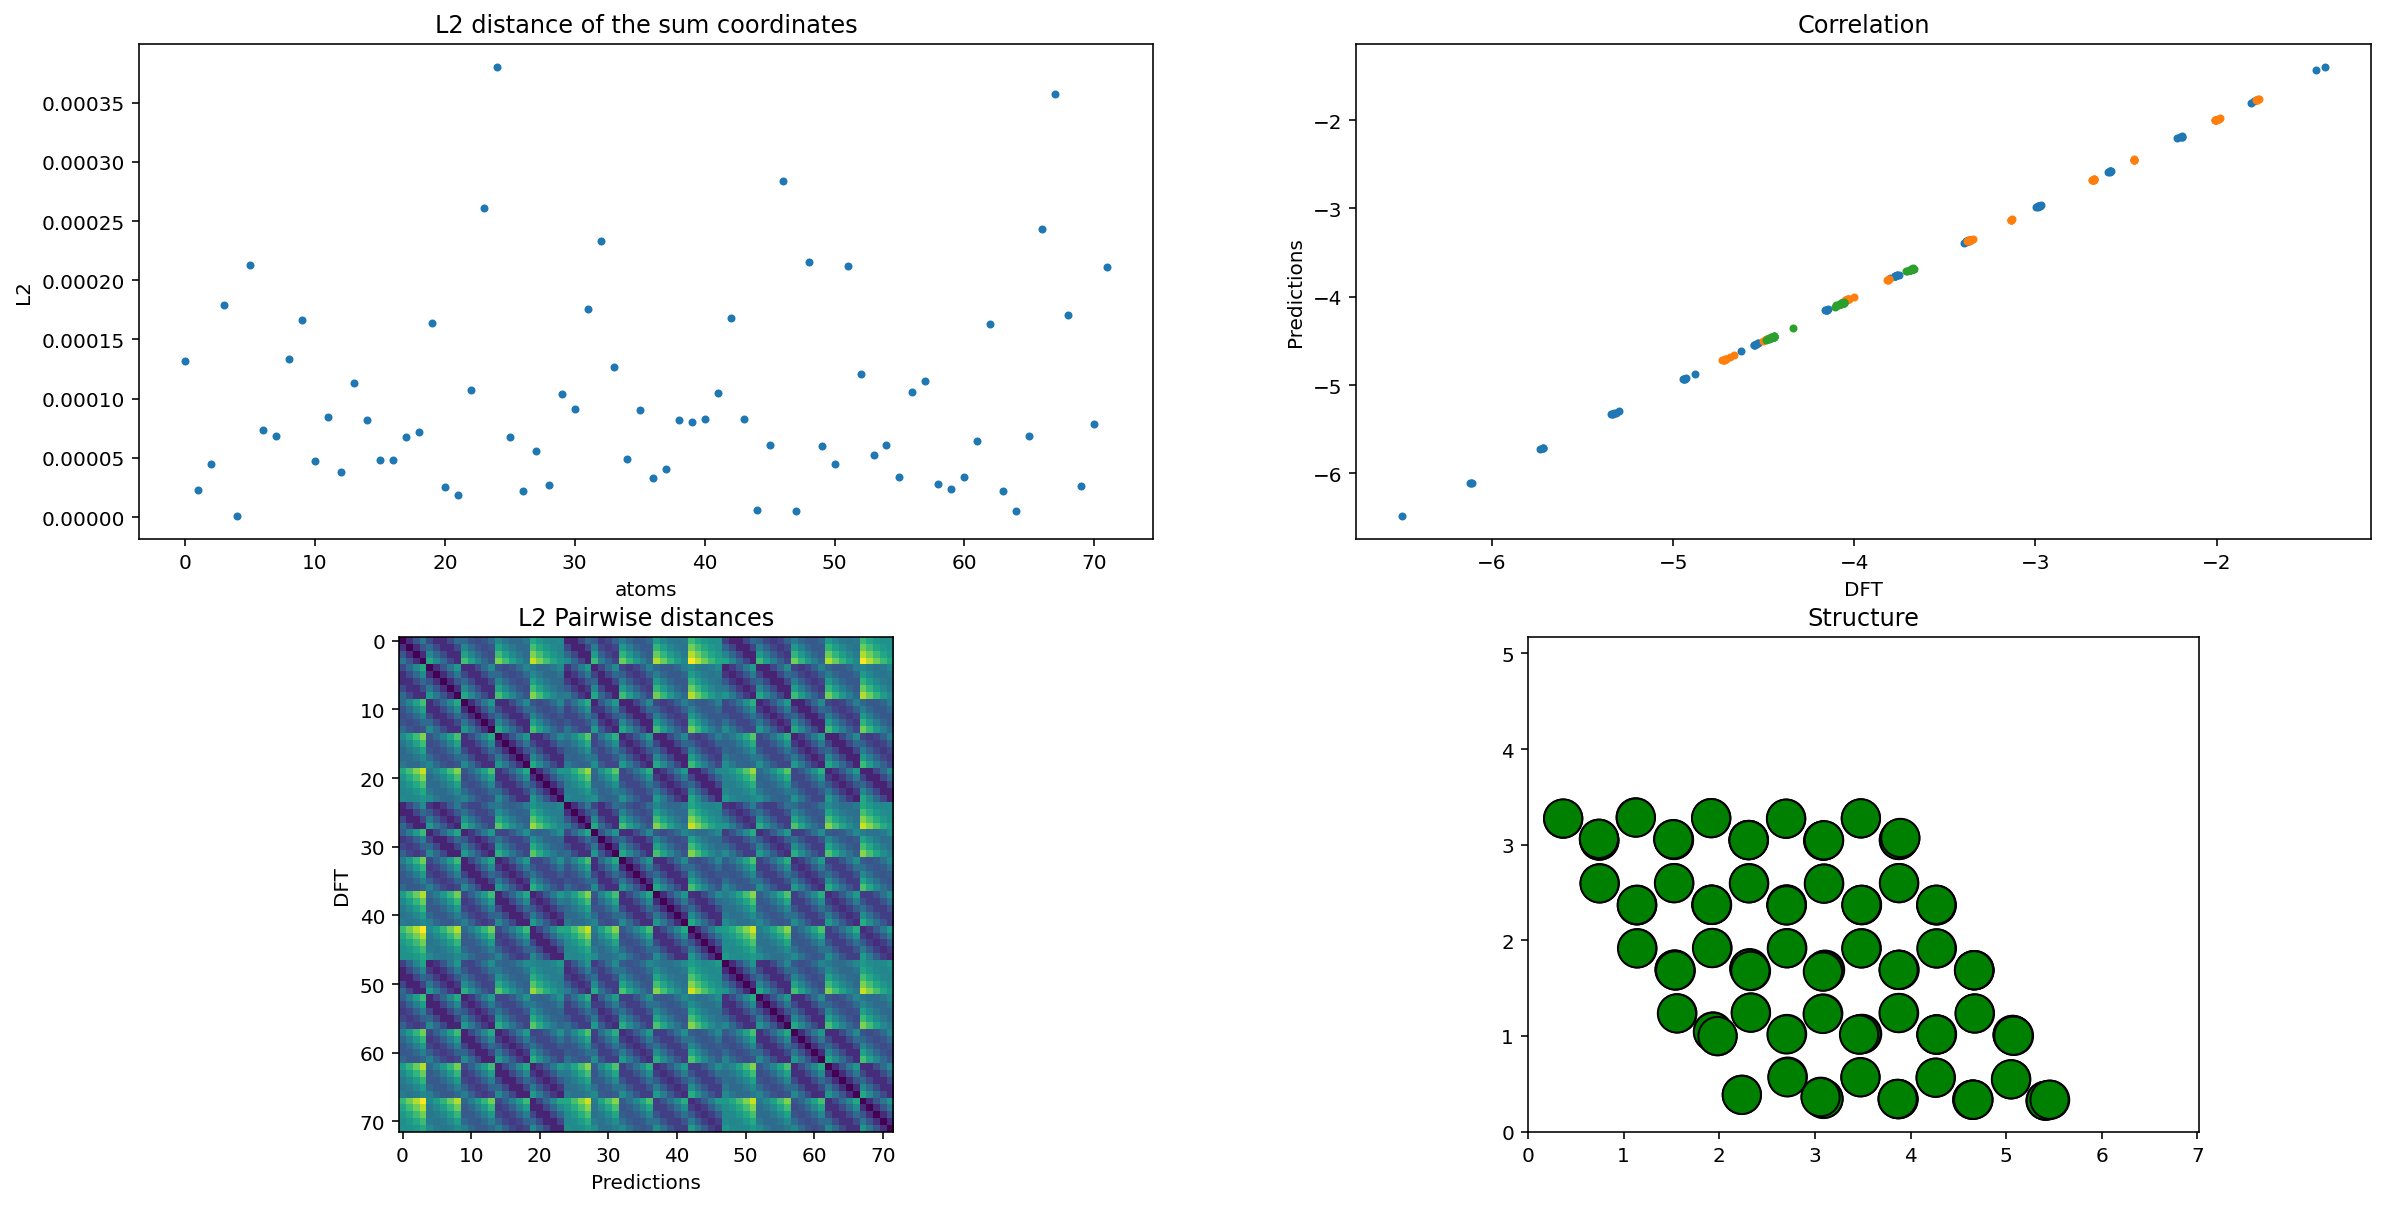

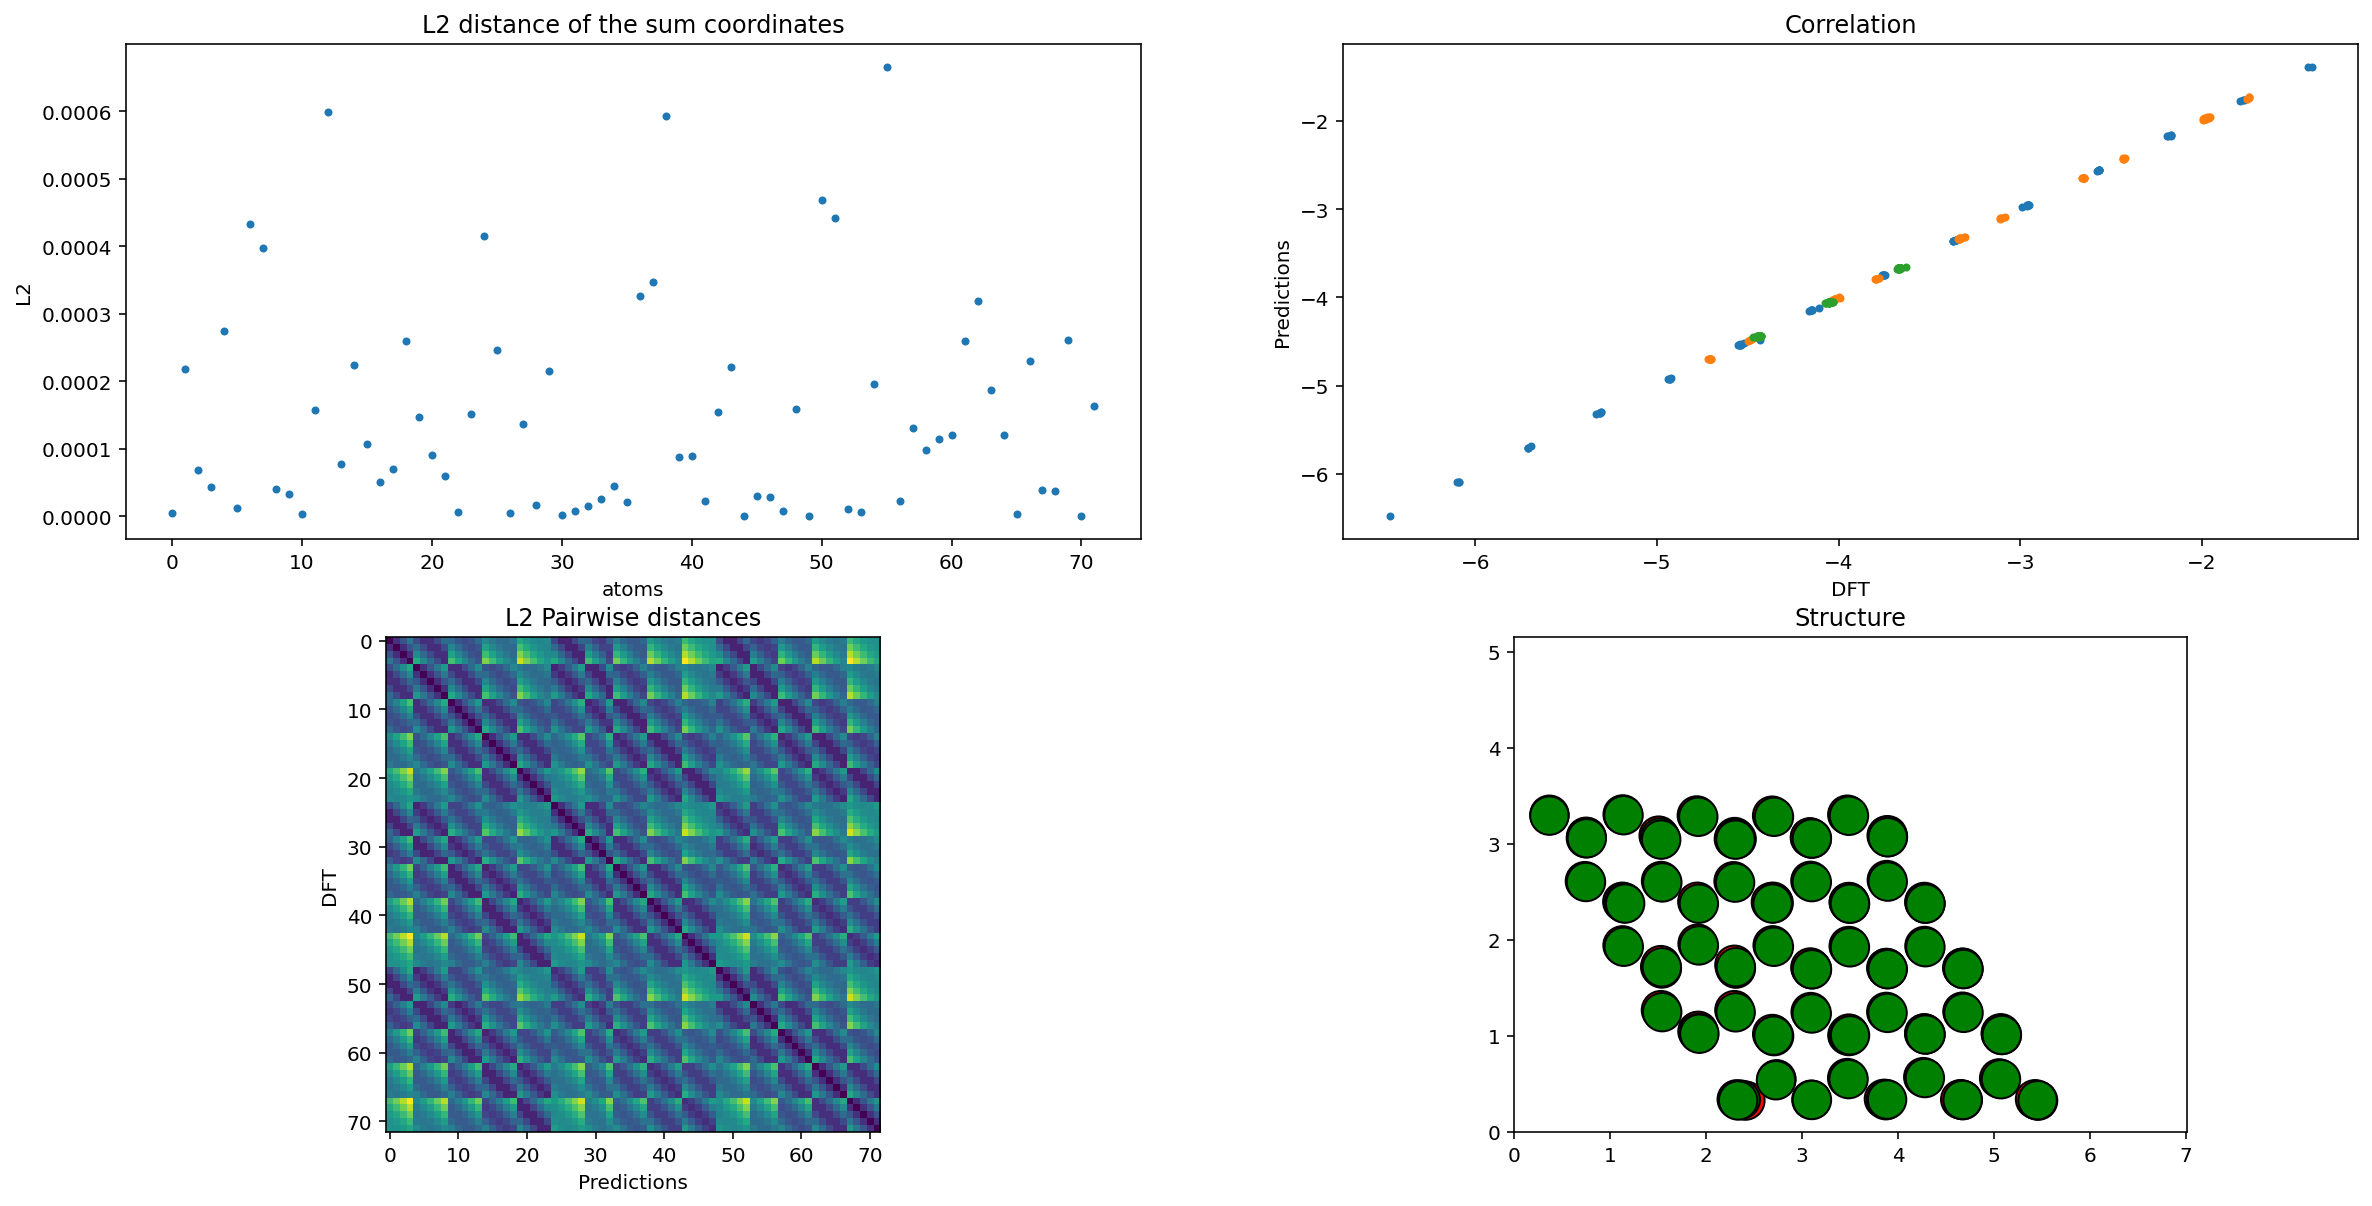

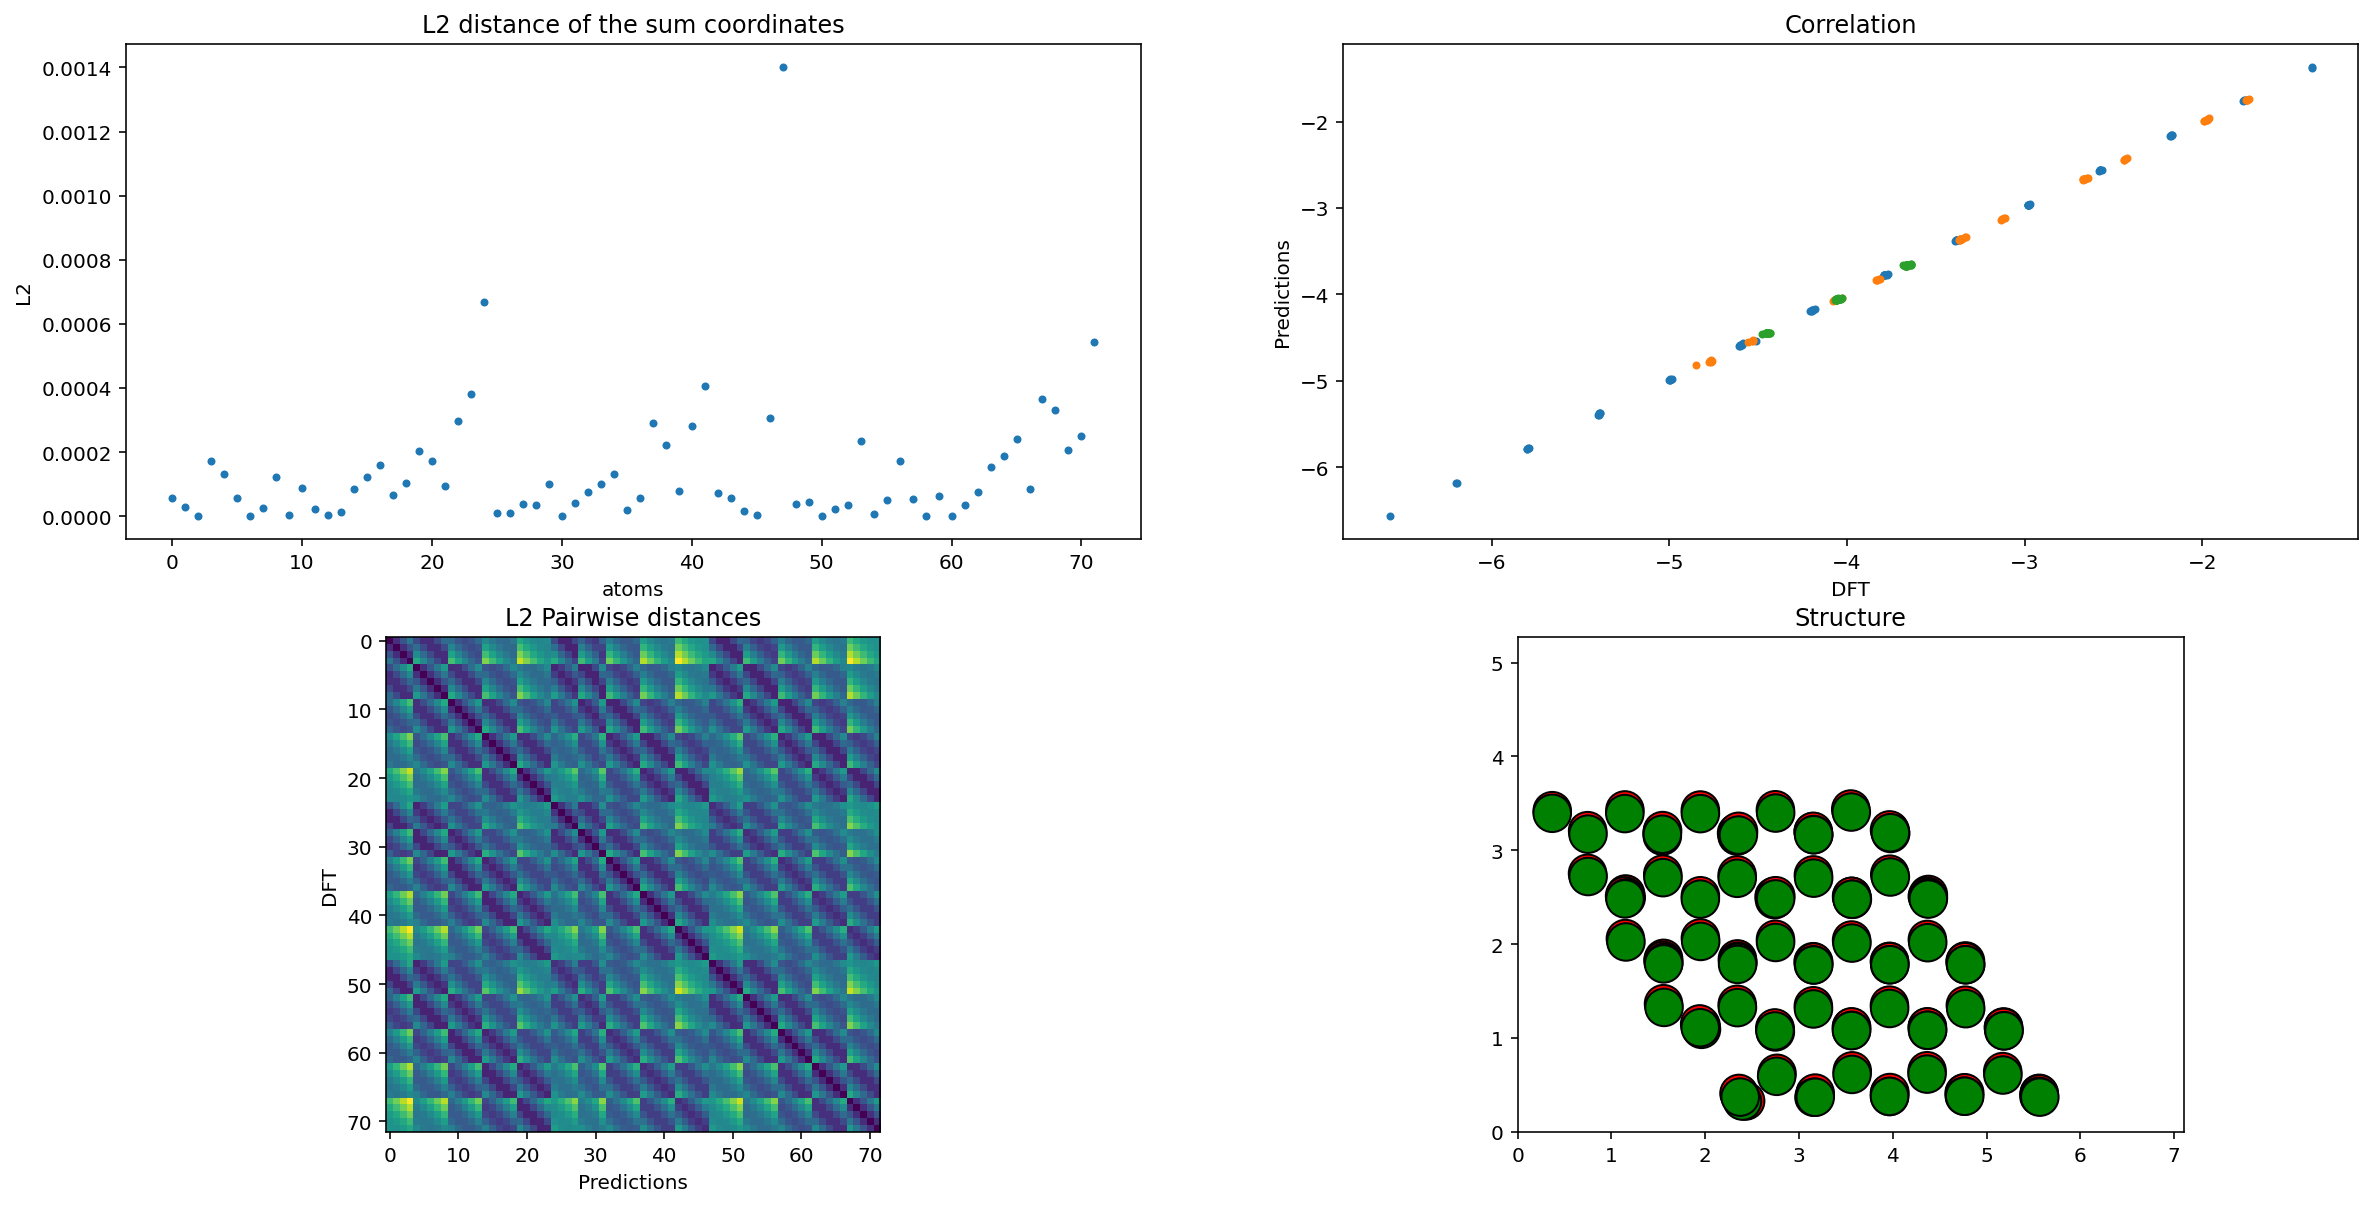

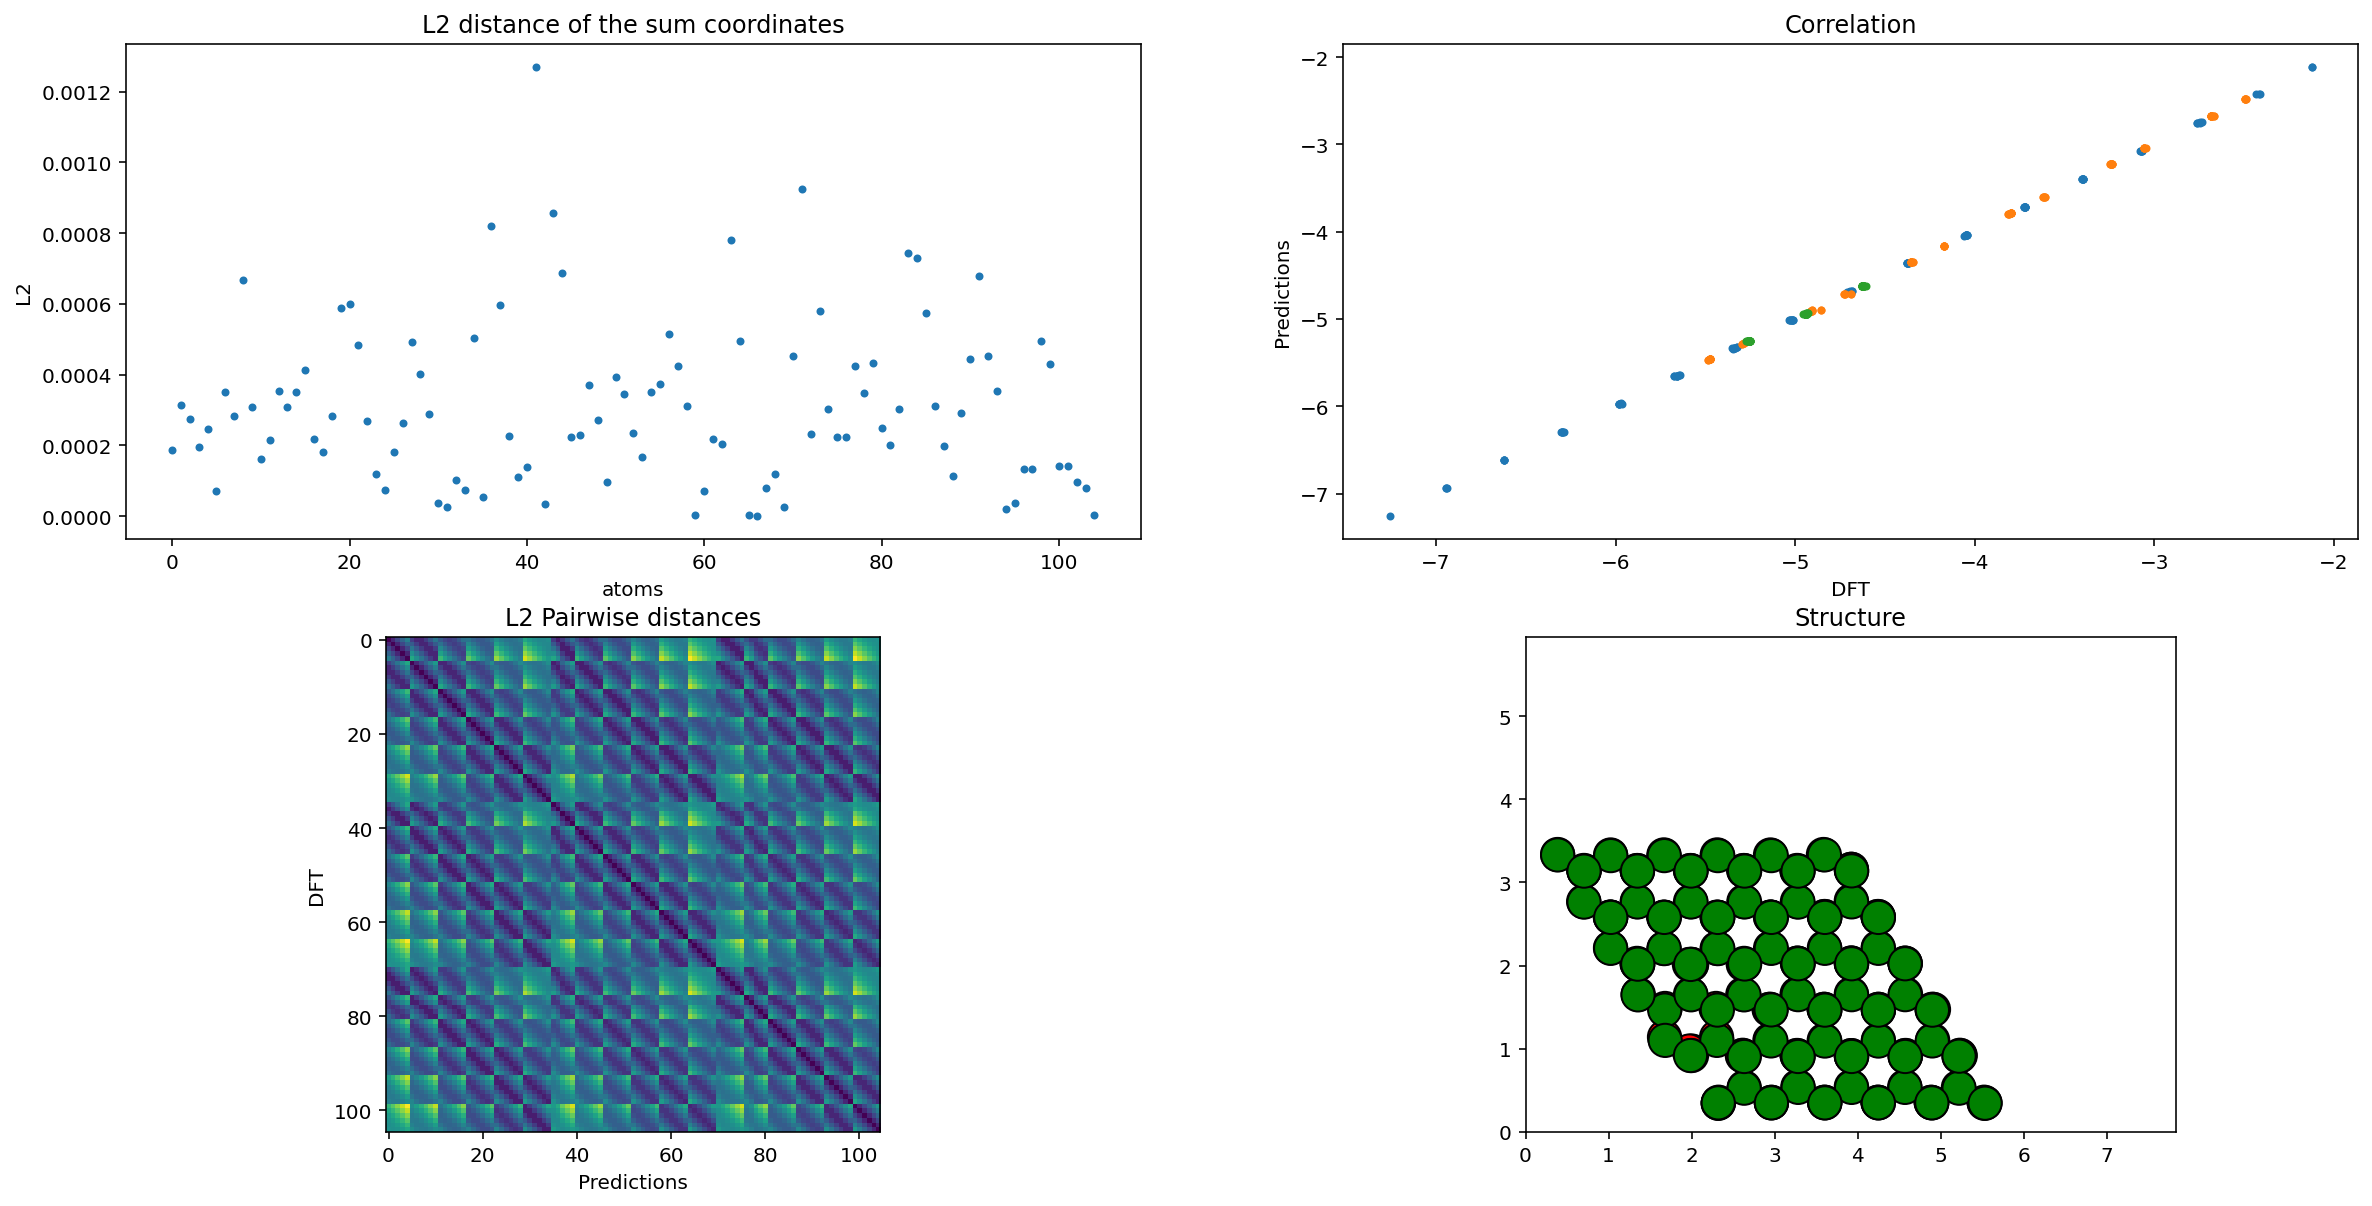

In [188]:
for i in range(5):  
    data = test_dataset[i+10]
    coord_pred, coord_target = valid(data)
    plot_analysis(coord_target, coord_pred[0])
    print(f'Sample #{i}')